<a href="https://colab.research.google.com/github/balajisadhasivam/Anomaly-Detection-/blob/main/Isolation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install imbalanced-learn

In [72]:
import numpy as np
import pandas as pd
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import cross_val_score
from imblearn.combine import SMOTETomek
from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [2]:
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

In [32]:
df = pd.read_csv('/content/creditcard_2023.csv',sep=',')
df

,id,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0,-0.260648,-0.469648,2.496266,-0.083724,0.129681,0.732898,0.519014,-0.130006,0.727159,...,-0.110552,0.217606,-0.134794,0.165959,0.126280,-0.434824,-0.081230,-0.151045,17982.10,0.0
1,1,0.985100,-0.356045,0.558056,-0.429654,0.277140,0.428605,0.406466,-0.133118,0.347452,...,-0.194936,-0.605761,0.079469,-0.577395,0.190090,0.296503,-0.248052,-0.064512,6531.37,0.0
2,2,-0.260272,-0.949385,1.728538,-0.457986,0.074062,1.419481,0.743511,-0.095576,-0.261297,...,-0.005020,0.702906,0.945045,-1.154666,-0.605564,-0.312895,-0.300258,-0.244718,2513.54,0.0
3,3,-0.152152,-0.508959,1.746840,-1.090178,0.249486,1.143312,0.518269,-0.065130,-0.205698,...,-0.146927,-0.038212,-0.214048,-1.893131,1.003963,-0.515950,-0.165316,0.048424,5384.44,0.0
4,4,-0.206820,-0.165280,1.527053,-0.448293,0.106125,0.530549,0.658849,-0.212660,1.049921,...,-0.106984,0.729727,-0.161666,0.312561,-0.414116,1.071126,0.023712,0.419117,14278.97,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245869,245869,1.700506,-0.417514,-0.090088,-0.376974,0.314310,-0.417960,0.546222,-0.235036,0.894088,...,-0.016096,0.645402,-0.075100,-0.128189,0.273385,-0.224514,-0.245784,-0.154176,1818.81,0.0
245870,245870,1.660014,-0.641142,0.409352,-0.445327,-0.043448,0.324526,0.192279,-0.121081,1.252307,...,-0.016209,0.729236,0.154960,0.155149,-0.651988,1.164440,-0.264553,-0.239042,286.22,0.0
245871,245871,1.446489,-1.177289,0.492814,-1.299574,-0.206396,1.069549,-0.022550,-0.044229,1.086852,...,-0.102011,0.432289,0.290469,-1.628222,-1.624016,1.915637,-0.191883,-0.157783,10772.13,0.0
245872,245872,1.818485,-0.398659,-0.075924,-0.446370,0.427669,-0.040776,0.490763,-0.200630,0.851098,...,-0.255421,-0.890536,0.325123,1.007128,-0.501110,0.405147,-0.310624,-0.176879,13163.73,0.0


In [33]:
df.shape

(245874, 31)

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245874 entries, 0 to 245873
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   id      245874 non-null  int64  
 1   V1      245874 non-null  float64
 2   V2      245874 non-null  float64
 3   V3      245874 non-null  float64
 4   V4      245874 non-null  float64
 5   V5      245874 non-null  float64
 6   V6      245874 non-null  float64
 7   V7      245874 non-null  float64
 8   V8      245874 non-null  float64
 9   V9      245874 non-null  float64
 10  V10     245874 non-null  float64
 11  V11     245874 non-null  float64
 12  V12     245874 non-null  float64
 13  V13     245874 non-null  float64
 14  V14     245874 non-null  float64
 15  V15     245874 non-null  float64
 16  V16     245874 non-null  float64
 17  V17     245874 non-null  float64
 18  V18     245874 non-null  float64
 19  V19     245874 non-null  float64
 20  V20     245874 non-null  float64
 21  V21     24

# Setting Target Variable

In [35]:
#List of column names from the df
columns = df.columns.tolist()
columns = [c for c in columns if c not in ["Class"]]
target = "Class"
state = np.random.RandomState(42)
X = df[columns]
Y = df[target]
print(X.shape)
print(Y.shape)

(245874, 30)
(245874,)


# Exploratory Data Analysis

In [36]:
#Create a DataFrame using the features (X) data
df = pd.DataFrame(X)
df['y'] = Y
#Check for missing values in df
print(df.isnull().sum())

id        0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       1
V26       1
V27       1
V28       1
Amount    1
y         1
dtype: int64


In [37]:
#Remove rows with missing values from the df inplace
df.dropna(inplace=True)
X = df.drop('y', axis=1)
Y = df['y']

**SimpleImputer**

In [38]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='mean')
#Fit the imputer to the data, calculate the mean for each features
# and transform the data by replacing missing values with the mean
X = imputer.fit_transform(X)

Text(0, 0.5, 'Frequency')

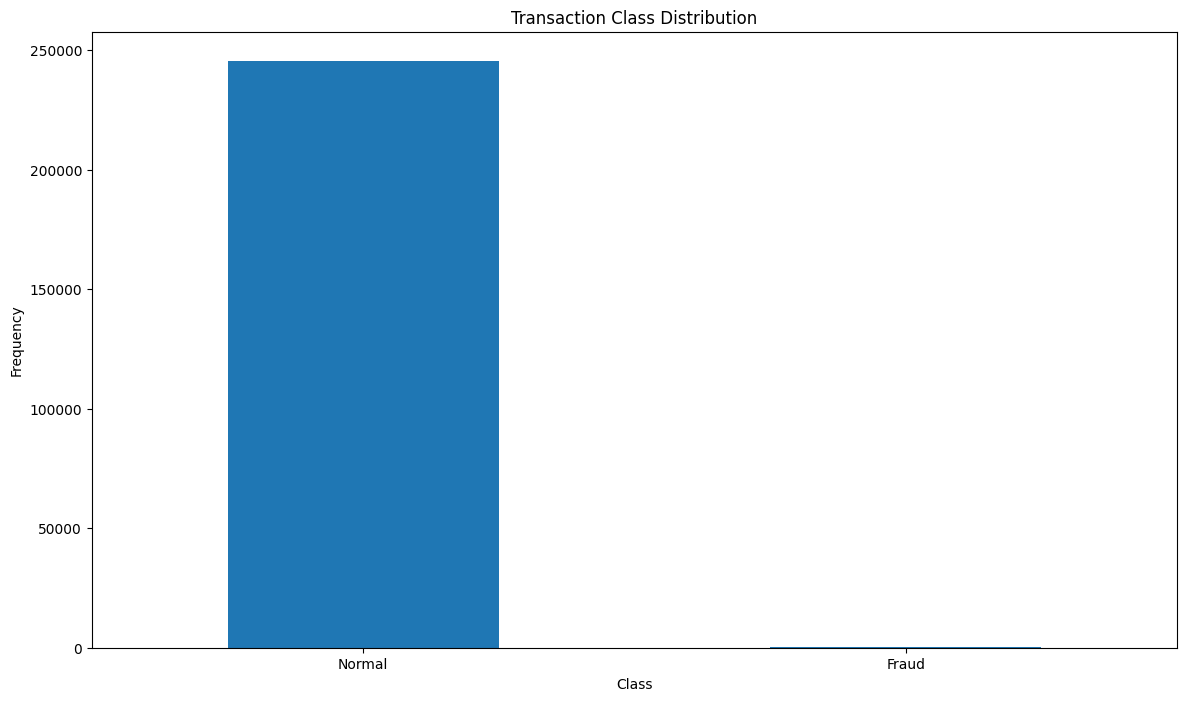

In [39]:
count_classes = pd.value_counts(df['y'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction Class Distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")

# Separating data into Two subsets
1.   Fraudulent transactions
2.   Normal transactions




In [40]:
fraud = df[df['y']==1]
normal = df[df['y']==0]
print(fraud.shape,normal.shape)

(449, 31) (245424, 31)


# Now calculate the outlier fraction based on the number of fraudulent and normal transactions

In [41]:
outlier_fraction = len(fraud)/float(len(normal))
print(outlier_fraction)
print("Fraud Cases : {}".format(len(fraud)))
print("Normal Cases : {}".format(len(normal)))

0.0018294869287437251
Fraud Cases : 449
Normal Cases : 245424


# Correlation matrix of features in the df


1.   Create a heatmap using seaborn's heatmap function
2.   Pass the correlation matrix as the data to be plotted









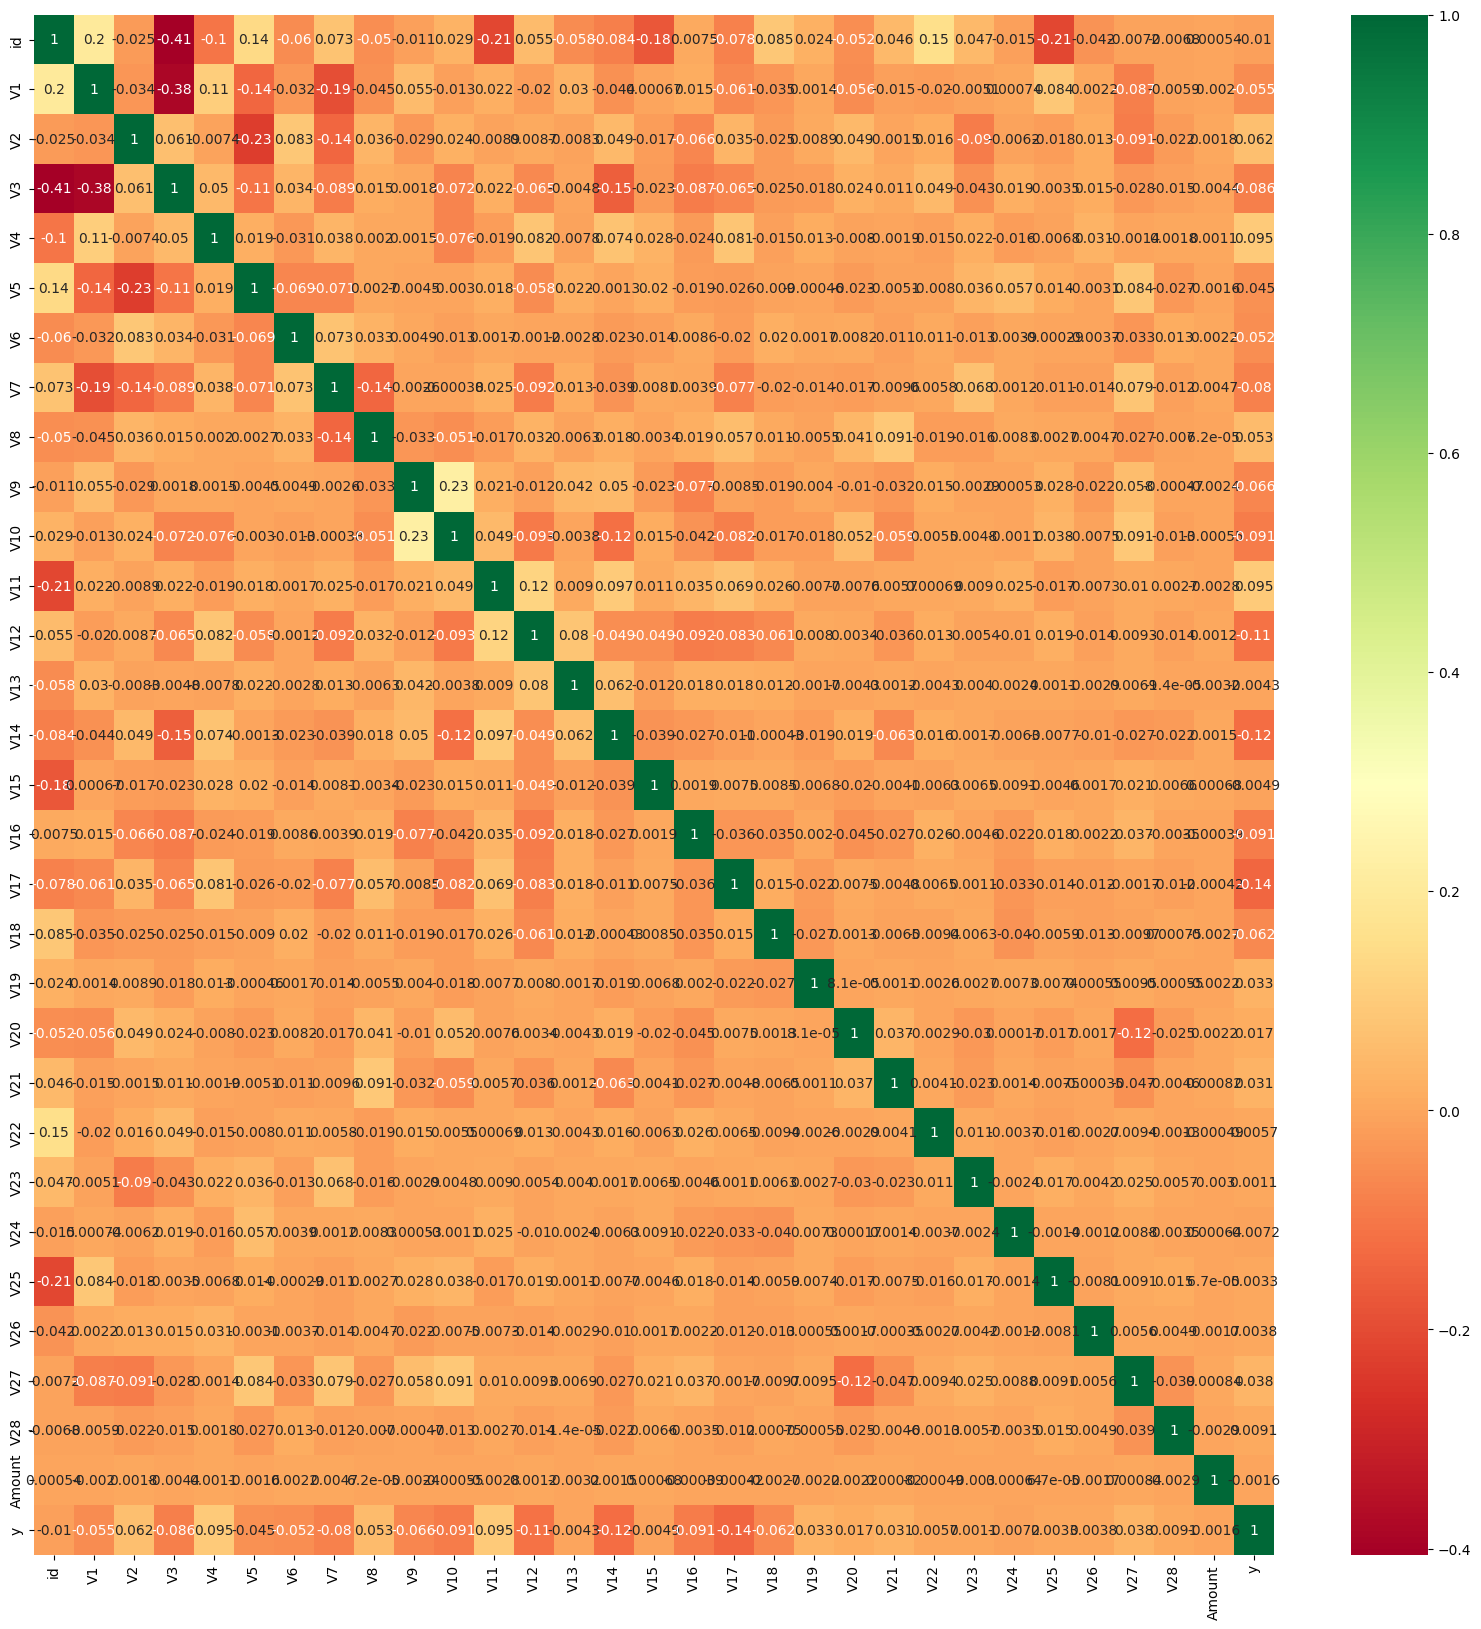

In [42]:
import seaborn as sns
corrmat = df.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
g=sns.heatmap(df[top_corr_features].corr(),annot=True,cmap="RdYlGn")

# Handling Imbalanced data
**SMOTETomek** is a hybrid resampling technique that combines the Synthetic Minority Over-sampling Technique (SMOTE) and Tomek links methods. It aims to address class imbalance in datasets by oversampling the minority class (using SMOTE) and undersampling the majority class (using Tomek links) simultaneously.

In this technique,
1.   Oversampling the fraudulent transactions
2.   Undersampling the normal transactions

in order to balance the dataset.


In [43]:
smk = SMOTETomek(random_state=42)
X_res,y_res=smk.fit_resample(X,Y)

In [44]:
X_res.shape

(482552, 30)

In [45]:
y_res.shape

(482552,)

# Counter

**Counter** is a built-in class in Python that is used for counting hashable objects.

In this cell, printing out the shapes of the original dataset and the resampled dataset using the Counter class.

By comparing the outputs of these cell, we can see how the class distribution has changed after resampling.

In [46]:
print('Original dataset shape {}'.format(Counter(Y)))
print('Resampled dataset shape {}'.format(Counter(y_res)))

Original dataset shape Counter({0.0: 245424, 1.0: 449})
Resampled dataset shape Counter({0.0: 241276, 1.0: 241276})


# Model


In [64]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.2, random_state=42)

In [65]:
X_train.shape

(386041, 30)

In [66]:
X_test.shape

(96511, 30)

In [67]:
nan = np.isnan(X_train).sum()
nan

0

In [69]:
txt_nan = np.isnan(X_test).sum()
txt_nan

0

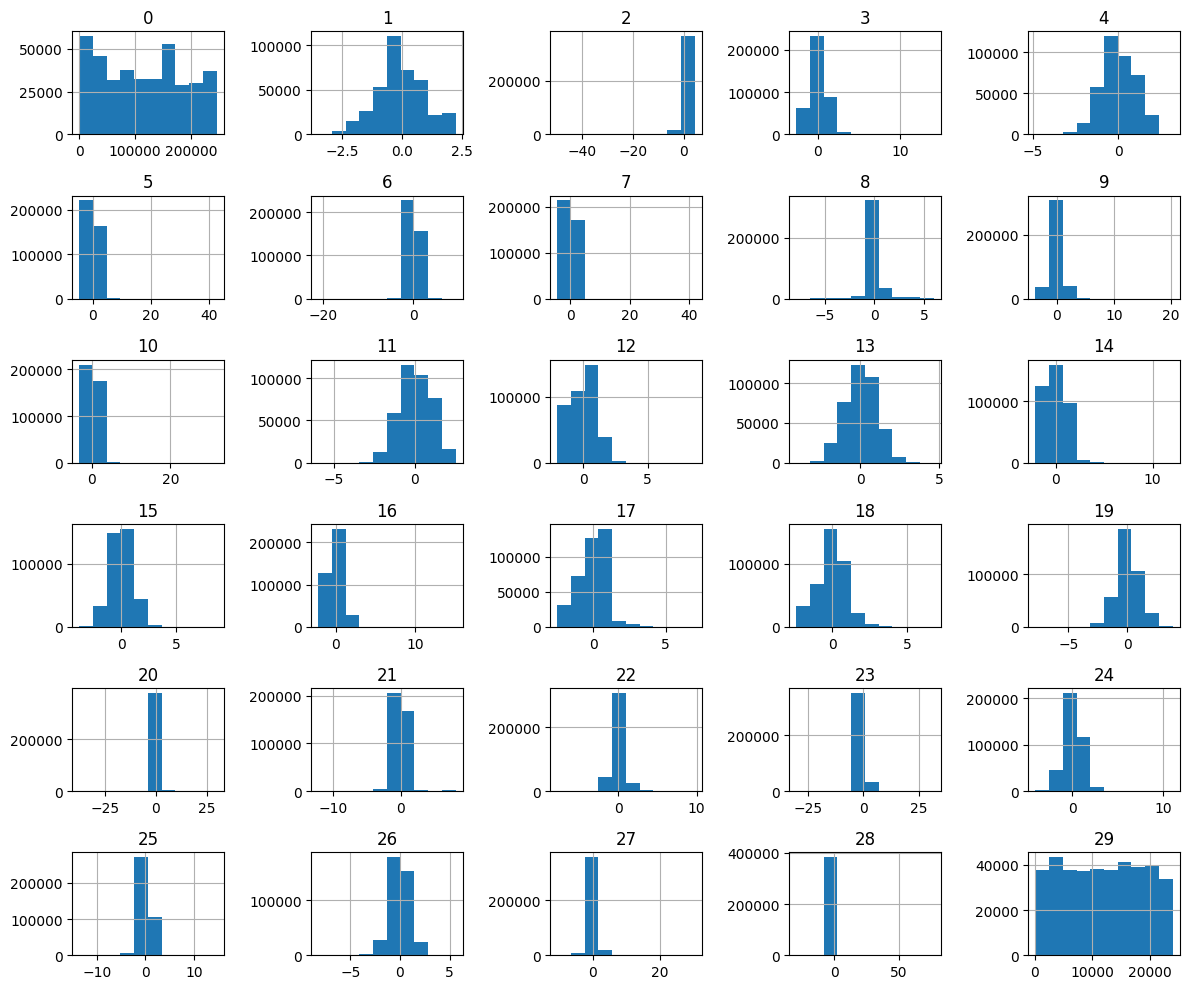

In [71]:
df_X_train = pd.DataFrame(X_train)
df_X_train.hist(figsize=(12, 10))
plt.tight_layout()
plt.show()

In [73]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

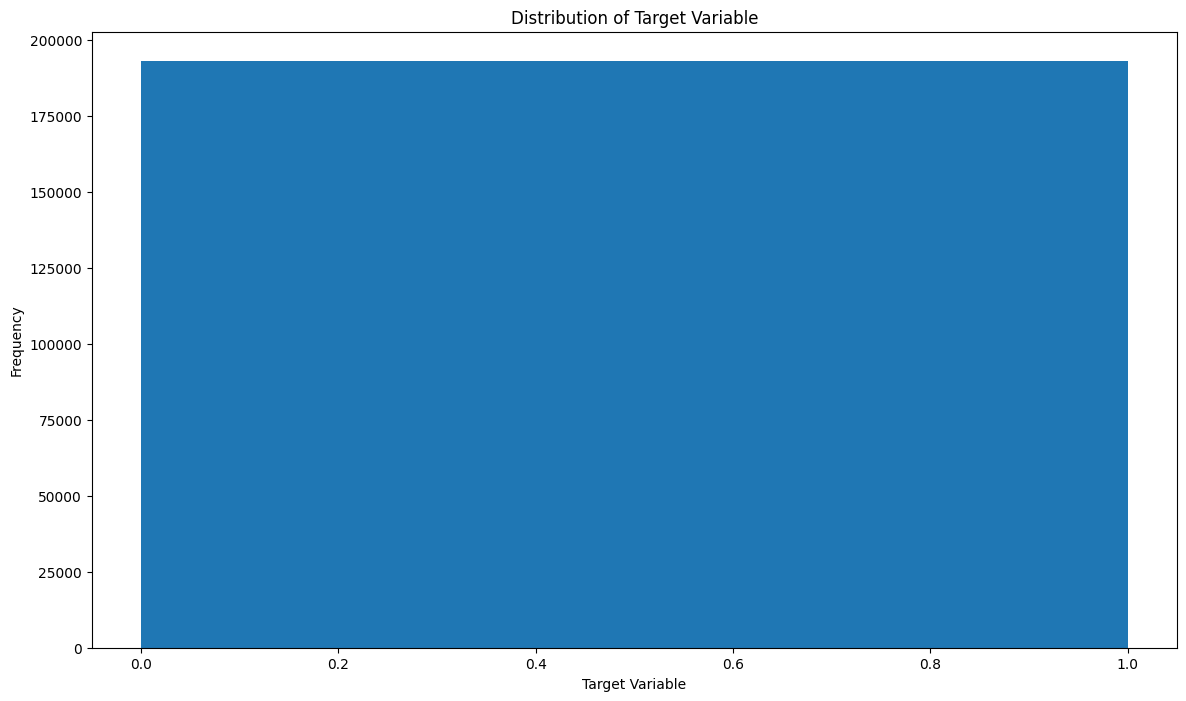

In [74]:
plt.hist(y_train, bins=2)
plt.xlabel('Target Variable')
plt.ylabel('Frequency')
plt.title('Distribution of Target Variable')
plt.show()

# Isolation Forests

One of the newest techniques for anomaly detection is the Isolation Forests algorithm, which leverages the inherent properties of anomalies being rare and distinct within a dataset. This algorithm capitalizes on the notion of isolation to effectively identify anomalies.

Isolation Forests stand out from traditional anomaly detection methods by introducing isolation as a more efficient and effective means of anomaly detection compared to conventional distance and density measures. Notably, the algorithm demonstrates low linear time complexity and minimal memory requirements, making it suitable for large-scale datasets.

Unlike typical machine learning methods that perform optimally on balanced datasets with equal representation of normal and anomalous observations, Isolation Forests excel in scenarios where anomalies are sparse.

The workings of the Isolation Forest algorithm involve isolating observations by randomly selecting features and split values within the dataset. The rationale behind this approach is intuitive: anomalies are easier to isolate because they require fewer conditions to separate them from normal observations, whereas normal observations necessitate more conditions. Consequently, an anomaly score is computed based on the number of conditions required to isolate a particular observation.

To achieve this, the algorithm constructs isolation trees, also known as random decision trees. The anomaly score is then derived as the path length needed to isolate the observation within these trees. By iteratively applying this process, Isolation Forests effectively pinpoint anomalies within datasets.

# GridSearch CV
GridSearchCV is a powerful technique in machine learning used for hyperparameter tuning, akin to a meticulous and exhaustive search for the optimal settings of a model amidst a vast array of possibilities. This method stands out as a reliable guide in the quest for fine-tuning machine learning algorithms to achieve superior performance. Its fundamental premise lies in the notion that the success of a model hinges greatly on the selection of appropriate hyperparameters, which govern the behavior and performance of the model.

This approach is particularly valuable as it meticulously explores the hyperparameter space, evaluating each combination's performance through a process akin to trial and error, akin to a seasoned explorer traversing through various routes to identify the most efficient path. GridSearchCV systematically tests different hyperparameter configurations, training and cross-validating the model on each setup to assess its effectiveness. Through this exhaustive exploration, GridSearchCV empowers data scientists and machine learning practitioners to identify the most optimal hyperparameters that yield the best performance for their specific task.

In [75]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_samples': [0.5, 0.7, 0.9],
    'contamination': [0.01, 0.05, 0.1]
}

In [78]:
classifier = IsolationForest(n_estimators=100, max_samples=len(X_train),contamination=outlier_fraction,random_state=42, verbose=0)
gs = GridSearchCV(classifier, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
gs.fit(X_train)
best_params = gs.best_params_
model = IsolationForest(**best_params, random_state=42)
model.fit(X_train)
y_pred = model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan]
  warnings.warn(


In [79]:
best_params

{'contamination': 0.01, 'max_samples': 0.5, 'n_estimators': 50}

In [80]:
y_pred

array([1, 1, 1, ..., 1, 1, 1])

In [52]:
print(y_test.shape)
print(y_pred.shape)

(96511,)
(96511,)


# Model Evaluation

In [53]:
y_pred[y_pred == 1] = 0  # Normal instances
y_pred[y_pred == -1] = 1  # Anomalies
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:", cm)
n_errors = cm[0, 1] + cm[1, 0]
print("Total Errors:", n_errors)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix: [[47908   356]
 [47630   617]]
Total Errors: 47986
Accuracy: 0.5027924278061568

Classification Report:
              precision    recall  f1-score   support

         0.0       0.50      0.99      0.67     48264
         1.0       0.63      0.01      0.03     48247

    accuracy                           0.50     96511
   macro avg       0.57      0.50      0.35     96511
weighted avg       0.57      0.50      0.35     96511



# Distribution of Anomaly Score and Visulaizing Anomalies

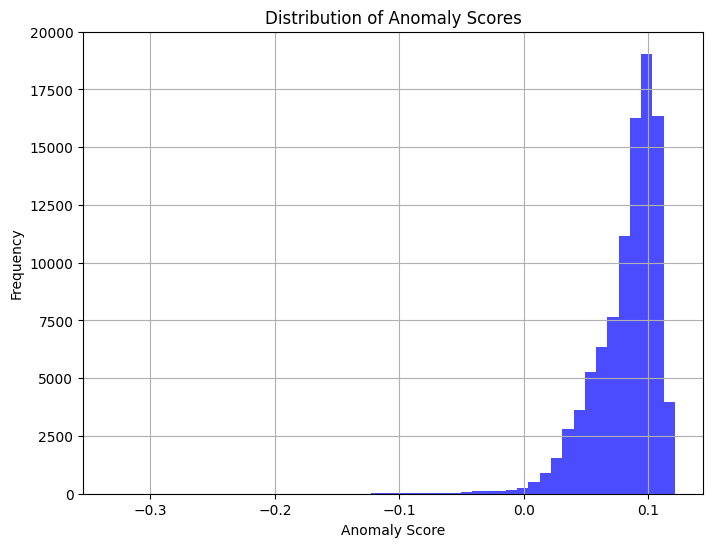

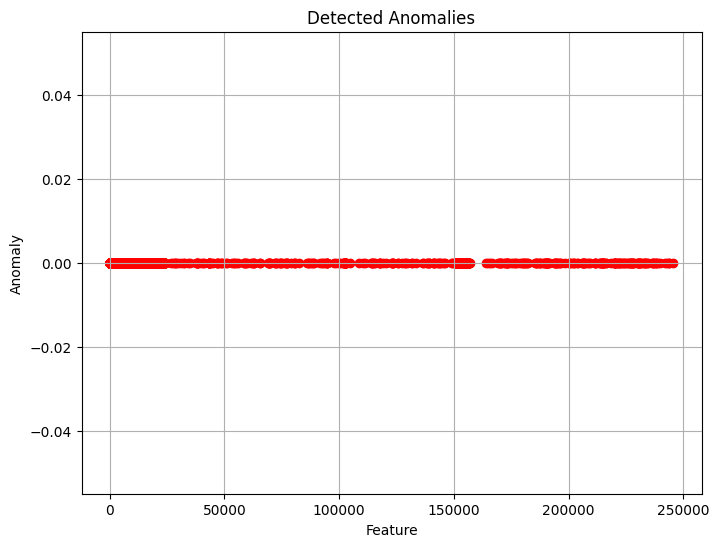

In [58]:
anomaly_scores = model.decision_function(X_test)
threshold = 0
anomalies = X_test[anomaly_scores < threshold]
#Anomaly Score
plt.figure(figsize=(8, 6))
plt.hist(anomaly_scores, bins=50, color='blue', alpha=0.7)
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.title('Distribution of Anomaly Scores')
plt.grid(True)
plt.show()
#Anomalies
if len(anomalies) > 0:
    plt.figure(figsize=(8, 6))
    plt.scatter(anomalies, np.zeros_like(anomalies), color='red')
    plt.xlabel('Feature')
    plt.ylabel('Anomaly')
    plt.title('Detected Anomalies')
    plt.grid(True)
    plt.show()
else:
    print("No anomalies detected.")